DENEME 1 2 

In [23]:
import pandas as pd
import numpy as np
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, average_precision_score
from sklearn import preprocessing
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [24]:
data = pd.read_csv("HR_comma_sep.csv")

In [25]:
print(data.shape)
data.head()

(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [28]:
data['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [36]:
data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [37]:
data.apply(lambda x: sum(x.isnull()))

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [38]:
var = ['sales','salary']
for v in var:
    print '\nFrequency count for variable %s'%v
    print data[v].value_counts()


Frequency count for variable sales
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

Frequency count for variable salary
low       7316
medium    6446
high      1237
Name: salary, dtype: int64


In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_to_encode = ['sales','salary']
for col in var_to_encode:
    data[col] = le.fit_transform(data[col])

In [44]:
data = pd.get_dummies(data, columns=var_to_encode)
data.columns

Index([u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_montly_hours', u'time_spend_company', u'Work_accident',
       u'left', u'promotion_last_5years', u'sales_0', u'sales_1', u'sales_2',
       u'sales_3', u'sales_4', u'sales_5', u'sales_6', u'sales_7', u'sales_8',
       u'sales_9', u'salary_0', u'salary_1', u'salary_2'],
      dtype='object')

In [46]:
y = data['left']
X = data.drop(['left'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [85]:
def modelfit(alg, X_train, y_train, predictors, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    y_pred = alg.predict(X_test)
    y_predprob = alg.predict_proba(X_test)[:,1]
    
    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, X_train, y_train, cv=5, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pred)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_predprob)
    
    print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
                
    #Print Feature Importance:
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[ 0.9855603   0.98513045  0.99123674  0.99030062  0.98929798]

Model Report
Accuracy : 0.9737
AUC Score (Train): 0.988209
CV Score : Mean - 0.9883052 | Std - 0.002496988 | Min - 0.9851305 | Max - 0.9912367


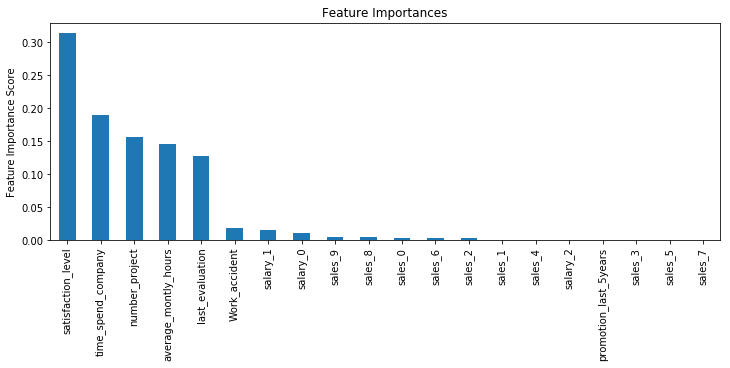

In [84]:
gbm0 = GradientBoostingClassifier(random_state=10)
predictors = [x for x in X_train.columns]
#print predictors
modelfit(gbm0, X_train, y_train,predictors)

In [87]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [88]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.98190, std: 0.00481, params: {'n_estimators': 20},
  mean: 0.98429, std: 0.00450, params: {'n_estimators': 30},
  mean: 0.98629, std: 0.00417, params: {'n_estimators': 40},
  mean: 0.98810, std: 0.00339, params: {'n_estimators': 50},
  mean: 0.98916, std: 0.00314, params: {'n_estimators': 60},
  mean: 0.98999, std: 0.00283, params: {'n_estimators': 70},
  mean: 0.99070, std: 0.00262, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.9907029164507897)

In [93]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [200, 400, 600, 800, 1000], 'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [94]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.98865, std: 0.00329, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.98847, std: 0.00349, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.98777, std: 0.00377, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.98683, std: 0.00342, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.98611, std: 0.00357, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.99193, std: 0.00206, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.99099, std: 0.00262, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.99037, std: 0.00282, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.98957, std: 0.00286, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.98857, std: 0.00380, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.99293, std: 0.00239, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.99249, std: 0.00228, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [103]:
param_test3 = {'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(min_samples_split=200, learning_rate=0.1, n_estimators=80,max_depth=15,
                                                    max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=200,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [30, 40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [104]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.99314, std: 0.00178, params: {'min_samples_leaf': 30},
  mean: 0.99350, std: 0.00235, params: {'min_samples_leaf': 40},
  mean: 0.99326, std: 0.00209, params: {'min_samples_leaf': 50},
  mean: 0.99291, std: 0.00203, params: {'min_samples_leaf': 60},
  mean: 0.99306, std: 0.00198, params: {'min_samples_leaf': 70}],
 {'min_samples_leaf': 40},
 0.9935019092513487)


Model Report
Accuracy : 0.988
AUC Score (Train): 0.992181
CV Score : Mean - 0.9936128 | Std - 0.001847789 | Min - 0.9904936 | Max - 0.9963052


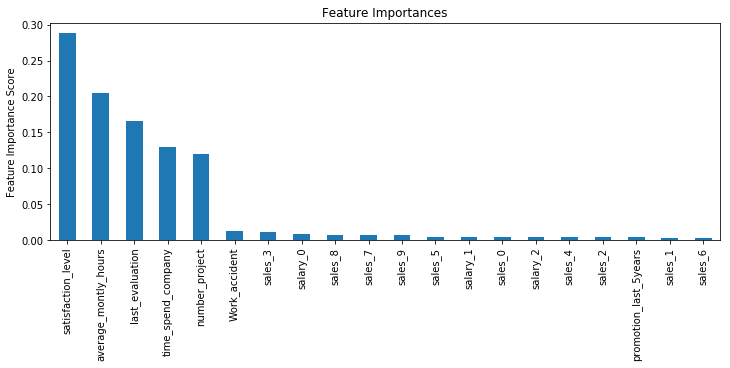

In [105]:
modelfit(gsearch2.best_estimator_, X_train, y_train,predictors)


Model Report
Accuracy : 0.9793
AUC Score (Train): 0.991708
CV Score : Mean - 0.9935019 | Std - 0.002347068 | Min - 0.9892814 | Max - 0.996309


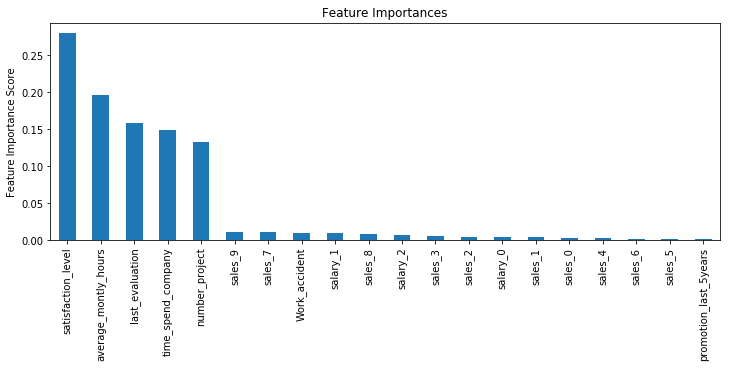

In [106]:
modelfit(gsearch3.best_estimator_, X_train, y_train,predictors)

In [116]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15, 
                            min_samples_split=200, min_samples_leaf=40, subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=40, min_samples_split=200,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [117]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.99355, std: 0.00226, params: {'max_features': 7},
  mean: 0.99389, std: 0.00202, params: {'max_features': 9},
  mean: 0.99404, std: 0.00195, params: {'max_features': 11},
  mean: 0.99391, std: 0.00230, params: {'max_features': 13},
  mean: 0.99361, std: 0.00227, params: {'max_features': 15},
  mean: 0.99348, std: 0.00253, params: {'max_features': 17},
  mean: 0.99344, std: 0.00234, params: {'max_features': 19}],
 {'max_features': 11},
 0.9940363665876297)

In [123]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15, 
                            min_samples_split=200, min_samples_leaf=40, subsample=0.8, random_state=10, max_features=11),
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features=11, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=40, min_samples_split=200,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [121]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.99349, std: 0.00210, params: {'subsample': 0.6},
  mean: 0.99391, std: 0.00236, params: {'subsample': 0.7},
  mean: 0.99382, std: 0.00237, params: {'subsample': 0.75},
  mean: 0.99391, std: 0.00230, params: {'subsample': 0.8},
  mean: 0.99386, std: 0.00260, params: {'subsample': 0.85},
  mean: 0.99395, std: 0.00236, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 0.993948870570722)


Model Report
Accuracy : 0.9837
AUC Score (Train): 0.991701
CV Score : Mean - 0.9940364 | Std - 0.001949616 | Min - 0.9909607 | Max - 0.9967475


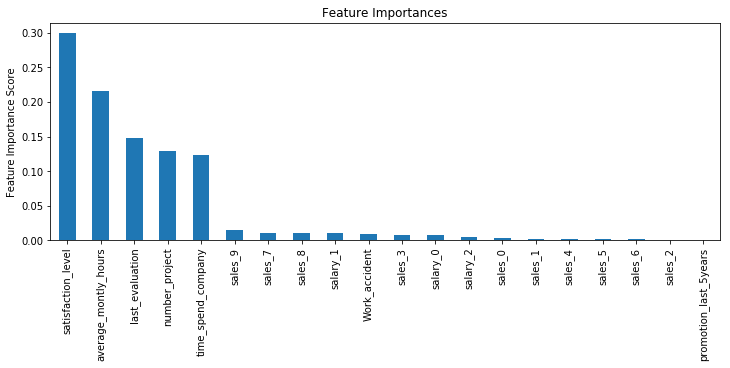

In [125]:
gmb_final = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=15, 
                            min_samples_split=200, min_samples_leaf=40, subsample=0.8, random_state=10, max_features=11)

modelfit(gmb_final, X_train, y_train,predictors)